In [19]:
%reload_ext autoreload
%autoreload 2


In [20]:
from cereeberus import ReebGraph, MapperGraph, Interleave, Assignment
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

import time
import random
from tqdm import tqdm
import itertools
from multiprocessing import Pool
import time
import numpy as np


#  Timing the cost of the initalization and optimization using the assginement class

In [ ]:
def run_once_assgn(args):
    torus, line, n = args
    start = time.perf_counter()
    myAssgn = Assignment(torus, line, n)
    opt_start = time.perf_counter()
    myAssgn.optimize()
    end = time.perf_counter()
    return (end - start, end - opt_start)



In [15]:

total_time = []
optimization_time = []


# Warm-up run (avoid lazy init effects)
Assignment(ex_mg.torus(a=0, b=2, c=4, d=6, delta=1, seed=42), ex_mg.line(a=0, b=6, seed=0), 1).optimize()


for i in tqdm(range(1,51)):
    torus = ex_mg.torus(a=0, b=2, c=i+2, d=i+4, delta=1, seed=4)
    line = ex_mg.line(a=0, b=i+4, seed=0)
    n = int(np.ceil(i/4))

    batch = [(torus, line, n)] * 10

    with Pool(processes=10) as pool:
        results = pool.map(run_once_assgn, batch)
                           

    total = [r[0] for r in results]
    opt = [r[1] for r in results]

    total_time.append((np.mean(total), np.std(total)))
    optimization_time.append((np.mean(opt), np.std(opt)))

df = pd.DataFrame({"loop_size": list(range(1,51)),
    "total_time_mean": [x[0] for x in total_time],
    "total_time_std": [x[1] for x in total_time],
    "optimization_time_mean": [x[0] for x in optimization_time],
    "optimization_time_std": [x[1] for x in optimization_time],
    })
df.to_csv("torus_line_benchmark_parallel_assgn.csv", index=False)


100%|██████████| 50/50 [21:14<00:00, 25.49s/it]


In [25]:
def run_once_assgn_dist(args):
    torus, line, n = args
    start = time.perf_counter()
    myAssgn = Assignment(torus, line, n=1)
    # call dist  matrix to initialize before optimization
    D = myAssgn.D_
    opt_start = time.perf_counter()
    myAssgn.dist_optimize()
    end = time.perf_counter()
    return (end - start, end - opt_start)


In [26]:
total_time = []
optimization_time = []


# Warm-up run (avoid lazy init effects)
Assignment(ex_mg.torus(a=0, b=2, c=4, d=6, delta=1, seed=42), ex_mg.line(a=0, b=6, seed=0), 1).dist_optimize()


for i in tqdm(range(1,51)):
    torus = ex_mg.torus(a=0, b=2, c=i+2, d=i+4, delta=1, seed=4)
    line = ex_mg.line(a=0, b=i+4, seed=0)
    n = int(np.ceil(i/4))

    batch = [(torus, line, n)] * 10

    with Pool(processes=10) as pool:
        results = pool.map(run_once_assgn_dist, batch)
                           

    total = [r[0] for r in results]
    opt = [r[1] for r in results]

    total_time.append((np.mean(total), np.std(total)))
    optimization_time.append((np.mean(opt), np.std(opt)))

df = pd.DataFrame({"loop_size": list(range(1,51)),
    "total_time_mean": [x[0] for x in total_time],
    "total_time_std": [x[1] for x in total_time],
    "optimization_time_mean": [x[0] for x in optimization_time],
    "optimization_time_std": [x[1] for x in optimization_time],
    })
df.to_csv("torus_line_benchmark_parallel_assgn_dist.csv", index=False)


100%|██████████| 50/50 [02:18<00:00,  2.76s/it]


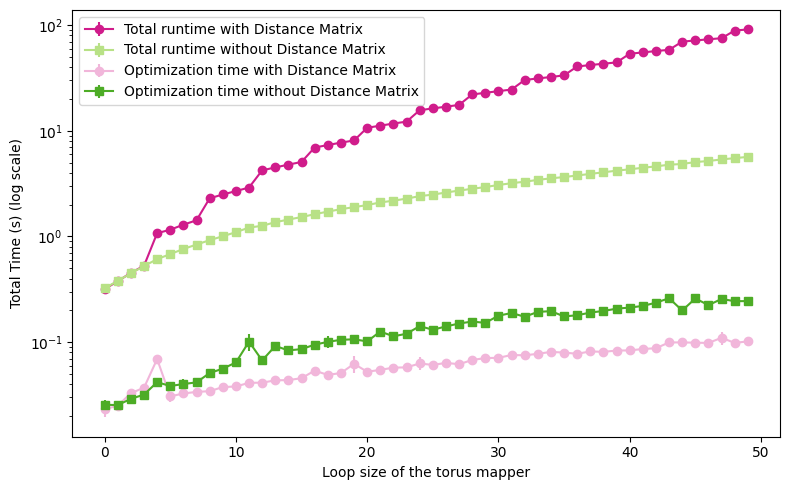

In [43]:
# read from csv
df1 = pd.read_csv("torus_line_benchmark_parallel_assgn.csv")
df2 = pd.read_csv("torus_line_benchmark_parallel_assgn_dist.csv")

import matplotlib.pyplot as plt
import numpy as np
x = np.arange(50)
#unpack dist means and stds
dist_means, dist_stds = zip(*df2[["total_time_mean", "total_time_std"]].values)
dist_opt_means, dist_opt_stds = zip(*df2[["optimization_time_mean", "optimization_time_std"]].values)
means, stds = zip(*df1[["total_time_mean", "total_time_std"]].values)
opt_means, opt_stds = zip(*df1[["optimization_time_mean", "optimization_time_std"]].values)

plt.figure(figsize=(8,5))

# colors
total_runtime_with_dist_color = "#d01c8b"
optimization_time_with_dist_color = "#f1b6da"
total_runtime_without_dist_color = "#b8e186"
optimization_time_without_dist_color = "#4dac26"

plt.errorbar(x, means, yerr=stds, label='Total runtime with Distance Matrix', fmt='-o', color=total_runtime_with_dist_color)
plt.errorbar(x, dist_means, yerr=dist_stds, label='Total runtime without Distance Matrix', fmt='-s', color=total_runtime_without_dist_color)
plt.errorbar(x, opt_means, yerr=opt_stds, label='Optimization time with Distance Matrix', fmt='-o', color=optimization_time_with_dist_color)
plt.errorbar(x, dist_opt_means, yerr=dist_opt_stds, label='Optimization time without Distance Matrix', fmt='-s', color=optimization_time_without_dist_color)
plt.xlabel('Loop size of the torus mapper')
plt.ylabel('Total Time (s) (log scale)')
# plt.title('Total Time vs Loop Size for Torus and Line Interleaving')
plt.legend()
plt.grid(False)
plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()
plt.savefig("torus_line_benchmark_hpcc.png", dpi=300) 
